Plotting CAMELS selection demonstration of Figure 7

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from astropy.cosmology import Planck15
from scipy.interpolate import InterpolatedUnivariateSpline as ius
import warnings
import h5py
warnings.simplefilter(action='ignore', category=FutureWarning) # many annoying dask warnings from bigfile
L = 25.0
V = L**3
c = 299792.458 #km/s
nJy = 1.0000e-23 


In [3]:
def bphi(Ns,Xs):
    #X = sigma8 or Dz
    # Function to compute (centered) FD derivative given some numberdensity tuple (Nm,N0,Np)
    # and corresponding redshift/s8 tuple (zm,z0,zp) in order of decreasing redshift (increasing a)
    # or increasing sigma8
    d1pX1,d1pX2 = Xs[0]-Xs[1],-(Xs[1]-Xs[2])
    reld1pX1,reld1pX2 = d1pX1/(Xs[1]),d1pX2/(Xs[1])
    bphi_hi = 2/reld1pX1 *(Ns[0]/Ns[1] -1) #low on N refers to low g-r, redshifts in dec order
    bphi_lo = 2/reld1pX2 *(Ns[2]/Ns[1] -1) 
    #averaging procedure of Barriera++20
    bphi = (bphi_hi + bphi_lo)/2.0
    return bphi


def bin_mask(pos,binsi,binsj,binsk):
    bin0i,bin1i = binsi
    bin0j,bin1j = binsj
    bin0k,bin1k = binsk
    return (((pos[:,0]>=bin1i) | (pos[:,0]<bin0i) ) |
            ((pos[:,1]>=bin1j) | (pos[:,1]<bin0j) ) |
            ((pos[:,2]>=bin1k) | (pos[:,2]<bin0k) ) )

def jackknife_bphi(position_m,position_0,position_p,
                   Xs, L,L_jk):
    # cut the box into (L/L_jk)**3 subboxes, return mean and variance of 
    # mean number density after dropping once subbox at a time
    V= L**3
    V_jk = V-(L_jk)**3
    N_sub_1d = int(L//L_jk)
    assert V%L_jk**3==0.0
    N_sub = N_sub_1d**3
    bins = np.linspace(0,L,N_sub_1d+1)
    rep_jk = np.zeros((N_sub_1d,N_sub_1d,N_sub_1d))
    for i in range(N_sub_1d):
        for j in range(N_sub_1d):
            for k in range(N_sub_1d):
                mask_m = bin_mask(position_m,bins[i:i+2],bins[j:j+2],bins[k:k+2])
                mask_0 = bin_mask(position_0,bins[i:i+2],bins[j:j+2],bins[k:k+2])
                mask_p = bin_mask(position_p,bins[i:i+2],bins[j:j+2],bins[k:k+2])
                n_m,n_0,n_p = np.sum(mask_m)/V_jk,np.sum(mask_0)/V_jk,np.sum(mask_p)/V_jk
                rep_jk[i,j,k] = bphi((n_m,n_0,n_p),Xs)
                
    mean =  np.mean(rep_jk) 
    var = (N_sub-1)*np.mean((rep_jk-mean)**2) 
    return mean,np.sqrt(var)

In [4]:
tng_path = "/home/jms3/camels_tng/"


In [5]:
# see here https://camels.readthedocs.io/en/latest/description.html
camels_scale_factors = np.loadtxt("/home/jms3/camels_tng/camels_snapshot_scale_factors.txt")
camels_snaps = np.array([ '{:03d}'.format(i) for i in range(len(camels_scale_factors))])
snap_dirlist = np.concatenate([[14,18,24,28],range(32,91,2)]) #not all of the groups have redshift output
avail_zs = (1./camels_scale_factors - 1.)[snap_dirlist]
avail_snaps = camels_snaps[snap_dirlist]
camels_zs_snaps = dict(zip(avail_zs, avail_snaps))

s8s = np.array([0.7, 0.8, 0.9]) 
Dzs = (1/1+avail_zs)[::-1] #EdS approximation 

In [6]:
zz,Dzs,fzs = np.loadtxt("./camels_fid_growth_factor_rate.txt").T
Dzs = ius(zz,Dzs)(avail_zs[::-1])

In [7]:
# example code https://camels.readthedocs.io/en/latest/photometry.html
def get_gmr_tng(z,s8_str="1P_p2_0",path=tng_path,observed=False,att_string='intrinsic'):
    if observed: light = 'flux'
    else: light = 'luminosity'
    #att_string is either attenuated or intrinsic
    # Snapshot number
    snap = camels_zs_snaps[z]
    # Subfind catalog name
    group_catalog = path+s8_str+'/'+f'groups_{snap}.hdf5'
    # Photometric catalog name
    pref = "IllustrisTNG" if path == tng_path else "Astrid"
    photo_catalog = path+pref+'_{0}_photometry.hdf5'.format("1P_p1_0") if (s8_str =="1P_p2_0" ) else path+pref+'_{0}_photometry.hdf5'.format(s8_str)
    # open the catalogue
    # from Chris' code for abs mag conversion in AB
    dm = 1.19649518e+40 #4*pi*(10 pc)^2 in cmsq 
    MAB = 48.6
    with h5py.File(photo_catalog, "r") as hf:
        # Get the subhalo index
        subhalo_index = np.array(hf[f"snap_{snap}/SubhaloIndex"][:], dtype=int)
        # Get the g-band magnitude
        g_band = -2.5*np.log10(hf[f"snap_{snap}/BC03/photometry/{light}/{att_string}/SLOAN/SDSS.g"][:] / dm) - MAB
        r_band = -2.5*np.log10(hf[f"snap_{snap}/BC03/photometry/{light}/{att_string}/SLOAN/SDSS.r"][:] / dm) - MAB
        i_band = -2.5*np.log10(hf[f"snap_{snap}/BC03/photometry/{light}/{att_string}/SLOAN/SDSS.i"][:] / dm) - MAB
    # we only need this if want to associate the g-band magnitude with the group properties
    with h5py.File(group_catalog, "r") as hf:
        M_star = hf['Subhalo/SubhaloMassType'][:,4]*1e10 # Stellar masses 
        halo_index = np.array(hf['Subhalo/SubhaloGrNr'][:])
        halo_mass200m = np.array(hf['Group/Group_M_Mean200'])[halo_index][:]*1e10 # Halo masses 
        subhalo_pos = np.array(hf['Subhalo/SubhaloPos'][:])/1e3 # Subhalo positions in Mpc/h
    # Filter stellar masses using the subhalo index
    M_star = M_star[subhalo_index]
    halo_mass200m = halo_mass200m[subhalo_index]
    subhalo_pos = subhalo_pos[subhalo_index]
    gminusr = g_band - r_band #intrinsic
    return gminusr, M_star, halo_mass200m, subhalo_pos, g_band, r_band, i_band

In [12]:
def get_all_s8_zs(zs, s8_str="1P_p2_0", path=tng_path, observed=False, att_string='attenuated'):
    return [get_gmr_tng(z,s8_str=s8_str,path=path,observed=observed,att_string=att_string) for z in zs]

# chris's pre-mask, M_r <-20, M_star > 1e8
def pre_mask(gmrqz):
    return (gmrqz[-1]>-20) & (gmrqz[1]>1e8)
def get_mask(gmrq,gmrbin,hmassbin=None,rbin=None, smassbin=None):
    gmr,smass,hmass,subhalo_pos,g,r,i= gmrq
    mask = (gmr>gmrbin[0]) & (gmr<=gmrbin[1])
    if smassbin is not None:
        mask = mask & (smass>smassbin[0]) & (smass<=smassbin[1])
    if hmassbin is not None:
        mask = mask & (hmass>hmassbin[0]) & (hmass<=hmassbin[1])
    if rbin is not None:
        mask = mask & (r>rbin[0]) & (r<=rbin[1])

    return mask, subhalo_pos[mask]

def get_mask_app(gmrq,app_mag,gmrbin=None,rbin=None,gbin=None,ibin=None):
    gmr,_,_,subhalo_pos,g,r,i= gmrq
    app_g,app_r,app_i = app_mag
    mask = np.ones(len(gmr),dtype=bool)
    if gmrbin is not None:
        mask = mask & (gmr>gmrbin[0]) & (gmr<=gmrbin[1])
    if gbin is not None:
        mask = mask & (app_g>gbin[0]) & (app_g<=gbin[1])
    if rbin is not None:
        mask = mask & (app_r>rbin[0]) & (app_r<=rbin[1])
    if ibin is not None:
        mask = mask & (app_i>ibin[0]) & (app_r<=ibin[1])
    return mask, subhalo_pos[mask]

def single_selection_bin_nbars(pos_s8mgmrqs,pos_s80gmrqs,pos_s8pgmrqs,s8s,L):
    # this is for a single selection bin
    nbars_SU_m = np.zeros(len(avail_zs)-2)
    nbars_SU_v = np.zeros(len(avail_zs)-2)
    nbars_Dz_m = np.zeros(len(avail_zs)-2)
    nbars_Dz_v = np.zeros(len(avail_zs)-2)
    for i in range(len(avail_zs)-2):
        if i>0 and i<len(avail_zs)-1: #FIXME LAZY
            nbars_SU_m[i], nbars_SU_v[i] = jackknife_bphi(pos_s8mgmrqs[i],pos_s80gmrqs[i],pos_s8pgmrqs[i],s8s,L,5.0)
            nbars_Dz_m[i], nbars_Dz_v[i] = jackknife_bphi(pos_s80gmrqs[i-1],pos_s80gmrqs[i],pos_s80gmrqs[i+1],Dzs[i-1:i+2],L,5.0)
    return nbars_SU_m,nbars_SU_v,nbars_Dz_m,nbars_Dz_v

# convert
def luminosity_distance(redshift, H0=67.74, Omega_m=0.3089, Omega_Lambda=0.6911,):
    c = 299792.458
    def E(z):
        return np.sqrt(Omega_m * (1 + z)**3 + Omega_Lambda)
    def luminosity_distance_integral(z):
        def integrand(z_prime):
            return 1 / E(z_prime)
        z_range = np.linspace(0, z, 1000)
        integrand_values = integrand(z_range)
        integral = np.trapz(integrand_values, z_range)
        return integral
    D_L = (1 + redshift) * c / H0 * luminosity_distance_integral(redshift)
    return D_L
def abs_to_app_noK(M,z):
    dL = luminosity_distance(z,Omega_m=0.3,Omega_Lambda=0.7)
    dist_mod = 5*np.log10(dL/(1e-5))
    return M + dist_mod

In [19]:
att_string = 'intrinsic'
s8mgmrqs = get_all_s8_zs(avail_zs,s8_str="1P_p2_n1",observed=False,att_string=att_string)
s80gmrqs = get_all_s8_zs(avail_zs,s8_str="1P_p2_0",observed=False,att_string=att_string)
s8pgmrqs = get_all_s8_zs(avail_zs,s8_str="1P_p2_1",observed=False,att_string=att_string)



In [79]:
# fix a particular bin to try this, gmr bin and halo mass bin
nbar_s8mgmrqs = [np.sum(( pre_mask(s8mgmrq) & get_mask(s8mgmrq,(0.4,np.inf),None,rbin=(-np.inf,-22))[0] ) )/V for i,s8mgmrq in enumerate(s8mgmrqs)]
nbar_s80gmrqs = [np.sum(( pre_mask(s80gmrq) & get_mask(s80gmrq,(0.4,np.inf),None,rbin=(-np.inf,-22))[0] ) )/V for i,s80gmrq in enumerate(s80gmrqs)]
nbar_s8pgmrqs = [np.sum(( pre_mask(s8pgmrq) & get_mask(s8pgmrq,(0.4,np.inf),None,rbin=(-np.inf,-22))[0] ) )/V for i,s8pgmrq in enumerate(s8pgmrqs)]
#positions
pos_s8mgmrqs = [get_mask(s8mgmrq,(-np.inf,0.3),None,rbin=(-21,-20))[1] for i,s8mgmrq in enumerate(s8mgmrqs)]
pos_s80gmrqs = [get_mask(s80gmrq,(-np.inf,0.3),None,rbin=(-21,-20))[1] for i,s80gmrq in enumerate(s80gmrqs)]
pos_s8pgmrqs = [get_mask(s8pgmrq,(-np.inf,0.3),None,rbin=(-21,-20))[1] for i,s8pgmrq in enumerate(s8pgmrqs)]

In [16]:
test_Mg_att_m = [s8mgmrqs[i][-3] for i in range(len(avail_zs))]
test_Mr_att_m = [s8mgmrqs[i][-2] for i in range(len(avail_zs))]
test_Mi_att_m = [s8mgmrqs[i][-1] for i in range(len(avail_zs))]

test_Mg_att_0 = [s80gmrqs[i][-3] for i in range(len(avail_zs))]
test_Mr_att_0 = [s80gmrqs[i][-2] for i in range(len(avail_zs))]
test_Mi_att_0 = [s80gmrqs[i][-1] for i in range(len(avail_zs))]

test_Mg_att_p = [s8pgmrqs[i][-3] for i in range(len(avail_zs))]
test_Mr_att_p = [s8pgmrqs[i][-2] for i in range(len(avail_zs))]
test_Mi_att_p = [s8pgmrqs[i][-1] for i in range(len(avail_zs))]

app_g_m = [abs_to_app_noK(test_Mg_att_m[z_idx],avail_zs[z_idx]) for z_idx in range(len(avail_zs))]
app_r_m = [abs_to_app_noK(test_Mr_att_m[z_idx],avail_zs[z_idx]) for z_idx in range(len(avail_zs))]
app_i_m = [abs_to_app_noK(test_Mi_att_m[z_idx],avail_zs[z_idx]) for z_idx in range(len(avail_zs))]

app_g_0 = [abs_to_app_noK(test_Mg_att_0[z_idx],avail_zs[z_idx]) for z_idx in range(len(avail_zs))]
app_r_0 = [abs_to_app_noK(test_Mr_att_0[z_idx],avail_zs[z_idx]) for z_idx in range(len(avail_zs))]
app_i_0 = [abs_to_app_noK(test_Mi_att_0[z_idx],avail_zs[z_idx]) for z_idx in range(len(avail_zs))]

app_g_p = [abs_to_app_noK(test_Mg_att_p[z_idx],avail_zs[z_idx]) for z_idx in range(len(avail_zs))]
app_r_p = [abs_to_app_noK(test_Mr_att_p[z_idx],avail_zs[z_idx]) for z_idx in range(len(avail_zs))]
app_i_p = [abs_to_app_noK(test_Mi_att_p[z_idx],avail_zs[z_idx]) for z_idx in range(len(avail_zs))]

/tmp/ipykernel_38501/698817876.py:55: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(integrand_values, z_range)
/tmp/ipykernel_38501/698817876.py:61: RuntimeWarning: divide by zero encountered in log10
  dist_mod = 5*np.log10(dL/(1e-5))


In [24]:
app_color_m = [(app_g_m[i],app_r_m[i],app_i_m[i]) for i in range(len(avail_zs))]
app_color_0 = [(app_g_0[i],app_r_0[i],app_i_0[i]) for i in range(len(avail_zs))]
app_color_p = [(app_g_p[i],app_r_p[i],app_i_p[i]) for i in range(len(avail_zs))]


In [25]:
def get_app_bphis_r_gmr(r_min,r_max,gmr_min,gmr_max):
    app_pos_s8mgmrqs = [get_mask_app(s8mgmrq,app_color_m[i],gmrbin=(gmr_min,gmr_max),rbin=(r_min,r_max))[1] for i,s8mgmrq in enumerate(s8mgmrqs)]
    app_pos_s80gmrqs = [get_mask_app(s80gmrq,app_color_0[i],gmrbin=(gmr_min,gmr_max),rbin=(r_min,r_max))[1] for i,s80gmrq in enumerate(s80gmrqs)]
    app_pos_s8pgmrqs = [get_mask_app(s8pgmrq,app_color_p[i],gmrbin=(gmr_min,gmr_max),rbin=(r_min,r_max))[1] for i,s8pgmrq in enumerate(s8pgmrqs)]
    return single_selection_bin_nbars(app_pos_s8mgmrqs,app_pos_s80gmrqs,app_pos_s8pgmrqs,s8s,L)

In [26]:
m_app_tng_nbars_SU_m,m_app_tng_nbars_SU_v,m_app_tng_nbars_Dz_m,m_app_tng_nbars_Dz_v =  get_app_bphis_r_gmr(-np.inf,27.,-np.inf,np.inf)
mm_app_tng_nbars_SU_m,mm_app_tng_nbars_SU_v,mm_app_tng_nbars_Dz_m,mm_app_tng_nbars_Dz_v =  get_app_bphis_r_gmr(25.,27.,-np.inf,np.inf)
mmc_app_tng_nbars_SU_m,mmc_app_tng_nbars_SU_v,mmc_app_tng_nbars_Dz_m,mmc_app_tng_nbars_Dz_v =  get_app_bphis_r_gmr(25.,27.7,0.3,0.8)


/tmp/ipykernel_38501/38303293.py:8: RuntimeWarning: invalid value encountered in scalar divide
  bphi_hi = 2/reld1pX1 *(Ns[0]/Ns[1] -1) #low on N refers to low g-r, redshifts in dec order
/tmp/ipykernel_38501/38303293.py:9: RuntimeWarning: invalid value encountered in scalar divide
  bphi_lo = 2/reld1pX2 *(Ns[2]/Ns[1] -1)
/tmp/ipykernel_38501/38303293.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  bphi_hi = 2/reld1pX1 *(Ns[0]/Ns[1] -1) #low on N refers to low g-r, redshifts in dec order
/tmp/ipykernel_38501/38303293.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  bphi_lo = 2/reld1pX2 *(Ns[2]/Ns[1] -1)


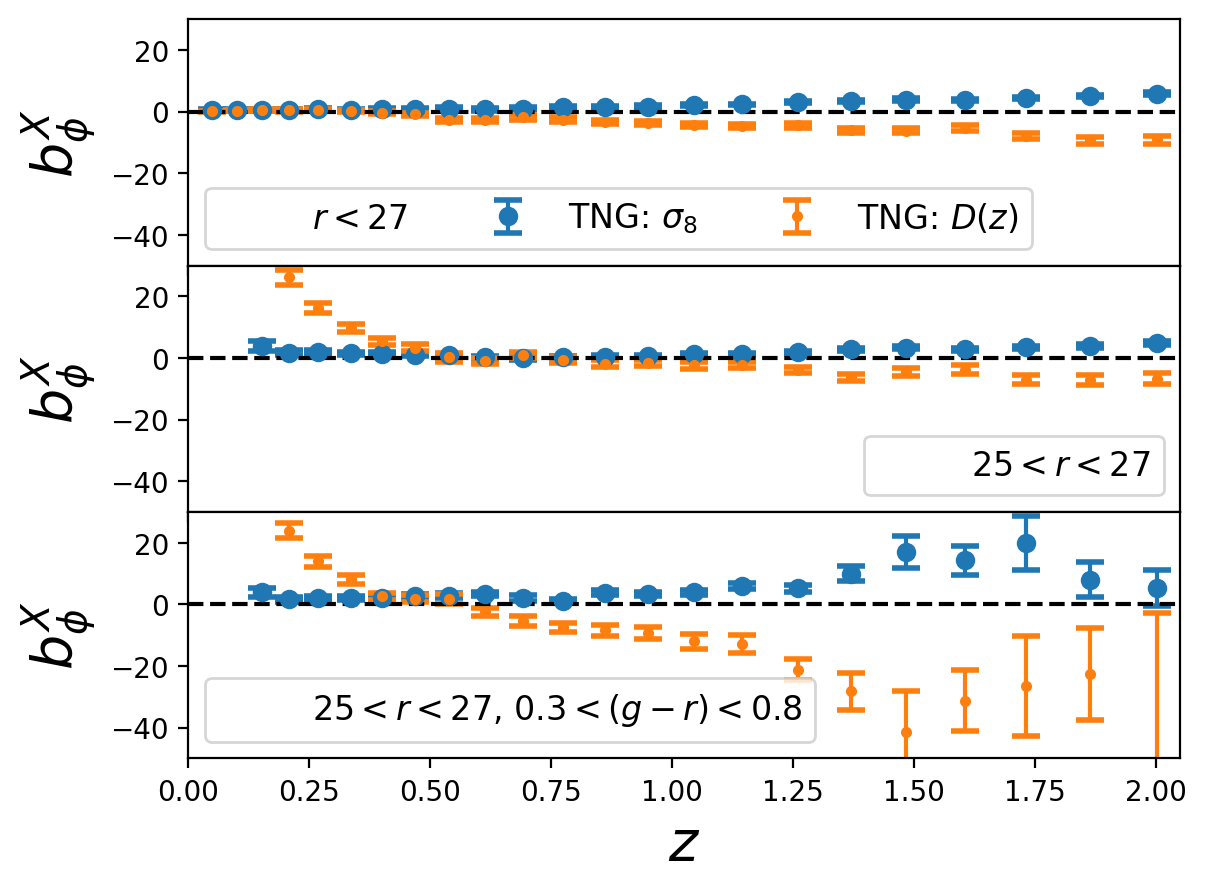

In [28]:
fig, axs = plt.subplots(3,sharex=True,sharey=True,
                       )

axs[0].errorbar(avail_zs[1:-1],m_app_tng_nbars_SU_m,yerr=m_app_tng_nbars_SU_v,capsize=5,capthick=2,fmt='o',label="TNG: "+r'$\sigma_8$')
axs[0].errorbar(avail_zs[1:-1],m_app_tng_nbars_Dz_m,yerr=m_app_tng_nbars_Dz_v,capsize=5,capthick=2,fmt='.',label="TNG: "+r'$D(z)$')
axs[1].errorbar(avail_zs[1:-1],mm_app_tng_nbars_SU_m,yerr=mm_app_tng_nbars_SU_v,capsize=5,capthick=2,fmt='o',)#label="TNG: "+r'$\sigma_8$')
axs[1].errorbar(avail_zs[1:-1],mm_app_tng_nbars_Dz_m,yerr=mm_app_tng_nbars_Dz_v,capsize=5,capthick=2,fmt='.',)#label="TNG: "+r'$D(z)$')
axs[2].errorbar(avail_zs[1:-1],mmc_app_tng_nbars_SU_m,yerr=mmc_app_tng_nbars_SU_v,capsize=5,capthick=2,fmt='o',)#label="TNG: "+r'$\sigma_8$')
axs[2].errorbar(avail_zs[1:-1],mmc_app_tng_nbars_Dz_m,yerr=mmc_app_tng_nbars_Dz_v,capsize=5,capthick=2,fmt='.',)#label="TNG: "+r'$D(z)$')
axs[0].plot(np.nan, np.nan, '-', color='none', label=r'$r < 27$')
axs[1].plot(np.nan, np.nan, '-', color='none', label=r'$25 < r < 27$')
axs[2].plot(np.nan, np.nan, '-', color='none', label=r'$25 < r < 27$'+', '+r'$0.3 < (g-r) < 0.8$')

plt.subplots_adjust(wspace=0, hspace=0)
axs[0].legend(prop={'size': 12},ncol=3)
axs[1].legend(prop={'size': 12},ncol=1,loc="lower right")
axs[2].legend(prop={'size': 12},ncol=1)
axs[0].set_xlim(0,2.05)
axs[0].set_ylim(-50,30)
axs[0].axhline(ls='--',c='k')
axs[1].axhline(ls='--',c='k')
axs[2].axhline(ls='--',c='k')
axs[0].set_ylabel(r"$b_{\phi}^{X}$",fontsize=20)
axs[1].set_ylabel(r"$b_{\phi}^{X}$",fontsize=20)
axs[2].set_ylabel(r"$b_{\phi}^{X}$",fontsize=20)
axs[2].set_xlabel(r"$z$",fontsize=20)
plt.savefig('./camels_tng_plots/app_3p_camels_bphi_gmr_0.3_0.8_app_r_25_27.png')
plt.savefig('./camels_tng_plots/app_3p_camels_bphi_gmr_0.3_0.8_app_r_25_27.pdf')
plt.show()